In [1]:
import datetime as dt

import numpy as np
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import pandas as pd

In [2]:
def plot_data(df):
    """
    Plot epi data over time.
    
    Parameters
    ----------
    df : pandas.Dataframe
        Epidemiological data in DataFrame format with 4 features:
        date, confirmed_cases, recovered_cases, death_cases
    """
    fig = plt.figure(figsize=(12, 8))
    axs = fig.subplots(nrows=3, ncols=1, sharex=True, squeeze=True)
    axs[0].plot(df.date, df.confirmed_cases, color='blue', linestyle='-', marker='None', label='Confirmed cases')
    axs[0].plot(df.date, df.recovered_cases, color='red', linestyle='-', marker='None', label='Recovered cases')
    axs[0].legend()
    axs[0].grid()
    axs[1].plot(df.date, df.confirmed_cases - df.recovered_cases, color='blue', linestyle='-', marker='None', label='Active cases')
    axs[1].legend()
    axs[1].grid()
    axs[2].plot(df.date, df.death_cases, color='blue', linestyle='-', marker='None', label='Deceased cases')
    axs[2].legend()
    axs[2].grid()
    plt.show()

        date  confirmed_cases  recovered_cases  death_cases
0 2020-02-26              1.0              0.0          0.0
1 2020-02-27              3.0              0.0          0.0
2 2020-02-28              3.0              0.0          0.0
3 2020-02-29              5.0              0.0          0.0
4 2020-03-01              6.0              0.0          0.0 
(...)
           date  confirmed_cases  recovered_cases  death_cases
176 2020-08-20           7074.0           5386.0        168.0
177 2020-08-21           7329.0           5472.0        168.0
178 2020-08-22           7594.0           5584.0        169.0
179 2020-08-23           7900.0           5678.0        170.0
180 2020-08-24           8175.0           5801.0        171.0


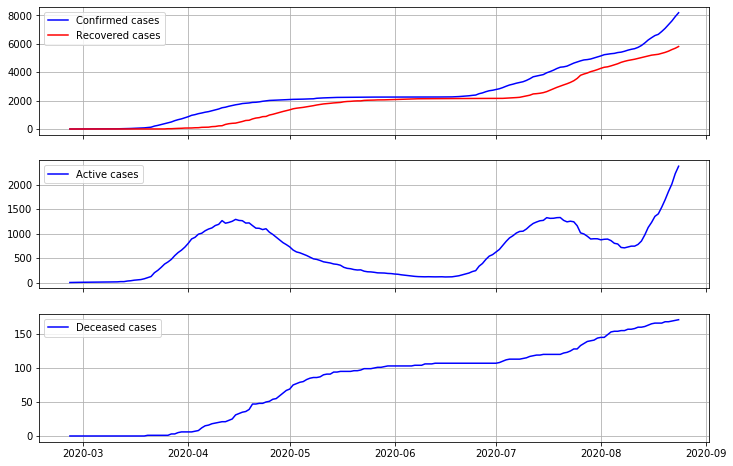

In [3]:
# data
confirmed_cases = np.loadtxt('../data/confirmed_cases.dat')
recovered_cases = np.loadtxt('../data/recovered_cases.dat')
death_cases = np.loadtxt('../data/death_cases.dat')

epidemics_start_date = dt.datetime(2020, 2, 26)
date_list = [epidemics_start_date + dt.timedelta(days=i) for i in range(confirmed_cases.size)]

# full data dataframe
df = pd.DataFrame({
    'date': date_list,
    'confirmed_cases': confirmed_cases,
    'recovered_cases': recovered_cases,
    'death_cases': death_cases,
})
print(df.head(), '\n(...)\n', df.tail())

# visualization of full data
plot_data(df)

        date  confirmed_cases  recovered_cases  death_cases
0 2020-06-02           2246.0           2077.0        103.0
1 2020-06-03           2246.0           2088.0        103.0
2 2020-06-04           2246.0           2095.0        103.0
3 2020-06-05           2247.0           2105.0        103.0
4 2020-06-06           2247.0           2113.0        103.0 
(...)
           date  confirmed_cases  recovered_cases  death_cases
176 2020-08-20           7074.0           5386.0        168.0
177 2020-08-21           7329.0           5472.0        168.0
178 2020-08-22           7594.0           5584.0        169.0
179 2020-08-23           7900.0           5678.0        170.0
180 2020-08-24           8175.0           5801.0        171.0


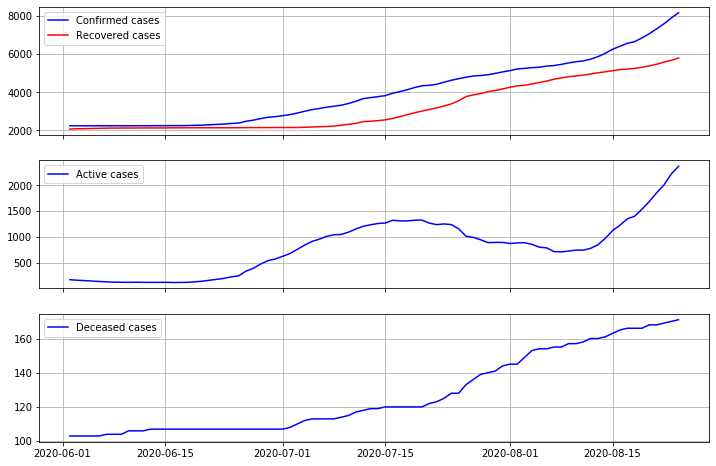

In [4]:
# second wave data dataframe
df_2 = df[df.date>dt.datetime(2020, 6, 1)]
df_2 = df_2.reset_index(drop=True)
print(df_2.head(), '\n(...)\n', df.tail())

# visualization
plot_data(df_2)

In [5]:
def normalize(data):
    """Return MinMax scaled data.
    
    Parameters
    ----------
    data : numpy.ndarray
        The data to be normalized.
    
    Returns
    -------
    numpy.ndarray
        Normalized data.
    """
    if isinstance(data, (np.ndarray)):
        assert data.ndim == 1, 'array must be 1-D'
    elif isinstance(data, (list)):
        data = np.array(data)
        assert data.ndim == 1, 'array must be 1-D'
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def restore(normalized, original):
    """Return restored data considering original data.
    
    Parameters
    ----------
    normalized : numpy.ndarray
        Scaled data.
    original : numpy.ndarray
        Original data.
    
    Returns
    -------
    numpy.ndarray
        Restored data.
    """
    if isinstance(normalized, (np.ndarray)) and isinstance(original, (np.ndarray)):
        assert normalized.ndim == 1 and original.ndim == 1, 'both arrays must be 1-D'
    elif isinstance(normalized, (list)) or isinstance(original, (list)):
        normalized = np.array(normalized)
        original = np.array(original)
        assert normalized.ndim == 1 and original.ndim == 1, 'both arrays must be 1-D'
    return normalized * (np.max(original) - np.min(original)) + np.min(original)


def _exp_func(x, a, b, c):
    """Exponential function of a single variable, x.
    
    Parameters
    ----------
    x : float or numpy.ndarray
        Input data.
    a : float
        First parameter.
    b : float
        Second parameter.
    c : float
        Third parameter.
    
    Returns
    -------
    float or numpy.ndarray
        a * exp(b * x) + c
    """
    return a * np.exp(b * x) + c


class ExponentialCOVIDModel(object):
    """A class to fit an exponential model to given data."""  
    def __init__(self, normalize=True):
        """Constructor.
        
        Parameters
        ----------
        normalize : bool, optional
            Should the data be normalized to [0, 1] range.
        """
        self.normalize = normalize
        
    def fit(self, confirmed_cases):
        """Fit the data to the exponential function.
        
        Parameters
        ----------
        confirmed_cases : numpy.ndarray
            Number of confirmed infected COVID-19 cases per day.
        
        Returns
        -------
        x : numpy.ndarray
            The independent variable where the data is measured.
        fitted : numpy.ndarray
            Fitted exponential function.
        """
        self.confirmed_cases = confirmed_cases

        if self.normalize:
            y = normalize(confirmed_cases)
        else: 
            y = confirmed_cases
    
        x = np.arange(confirmed_cases.size)
        self.popt, self.pcov = curve_fit(_exp_func, x, y)
        fitted = _exp_func(x, *self.popt) 
        if self.normalize: 
            fitted = restore(fitted, confirmed_cases)
        return x, fitted

    def predict(self, n_days):
        """Predict the future n_days using the fitted exponential function.
        
        Parameters
        ----------
        n_days : int
            Number of days to extrapolate.
        
        Returns
        -------
        x_future : numpy.ndarray
            The independent variable where the data is predicted.
        predicted : numpy.ndarray
            Extrapolated data.
        """
        assert isinstance(n_days, (int,)), 'Number of days must be integer.'
        size = self.confirmed_cases.size
        x_future = np.arange(size-1, size+n_days)
        predicted = _exp_func(x_future, *self.popt)
        if self.normalize: 
            predicted = restore(predicted, self.confirmed_cases)
        return x_future, predicted

In [6]:
def simulate(eff_date, confirmed_cases, n_days):
    """
    Fit the data to exponential function and plot n_days forecast.
        
    Parameters
    ----------
    eff_date : datetime.datetime
        Start date of simulation.
    confirmed_cases : numpy.ndarray
        Number of confirmed infected COVID-19 cases per day since eff_date.
    n_days : int
        Number of days to extrapolate.
    """
    date_list = [eff_date + dt.timedelta(days=i) for i in range(confirmed_cases.size)]
    offset = np.min(confirmed_cases)
    confirmed_cases_adjusted = confirmed_cases - offset
    exp_model = ExponentialCOVIDModel(normalize=True)
    x, fitted_curve = exp_model.fit(confirmed_cases_adjusted)
    x_future, predicted_curve = exp_model.predict(n_days)
    date_list_future = [date_list[-1] + dt.timedelta(days=i) for i in range(predicted_curve.size)]
    
    plt.figure(figsize=(12, 8))
    plt.plot(date_list, confirmed_cases_adjusted + offset, color='blue', linestyle='-', marker='o', label='Confirmed cases')
    plt.plot(date_list, fitted_curve + offset, color='red', linestyle='-', marker='None', label='Exponential fit')
    plt.plot(date_list_future, predicted_curve + offset, color='red', linestyle='--', marker='o',  label='Extrapolated curve')
    props = dict(boxstyle='round', facecolor='lavender', alpha=0.7)
    for idx, vals in enumerate(zip(date_list_future[1:], predicted_curve[1:] + offset)):
        plt.text(vals[0], vals[1] - 175, str(int(vals[1])), verticalalignment='top', bbox=props)
    plt.legend()
    plt.grid()
    plt.gcf().autofmt_xdate()
    plt.show()

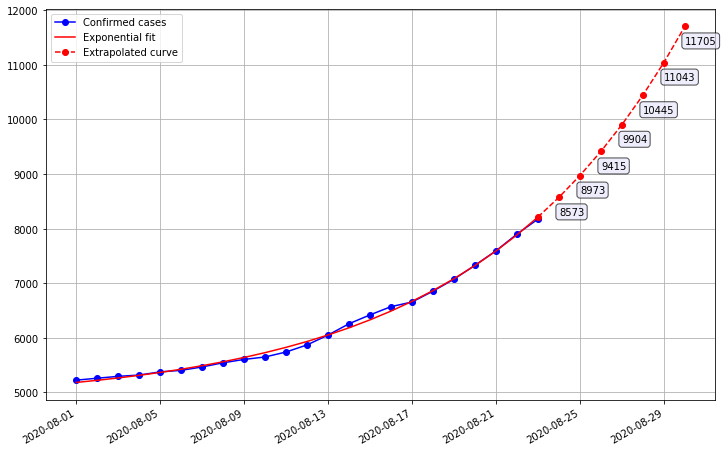

In [7]:
eff_date = dt.datetime(2020, 8, 1)
confirmed_cases = df_2[df_2.date > eff_date].confirmed_cases.values
n_days = 7

simulate(eff_date, confirmed_cases, n_days)